In [ ]:
# Importing libraries
import os
import cv2
import random 
import numpy as np 
import pandas as pd 
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, InceptionV3
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, concatenate, Conv2D, MaxPooling2D, Flatten
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

In [3]:
# Settig parameters
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-4
NUM_CLASSES = 3

In [4]:
# Ignoring warning messages
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Loading the dataset CSV files
train = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')
train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [6]:
# Displaying number of samples
print('Number of train samples: ', train.shape[0])

Number of train samples:  3662


In [7]:
print("\nTrain dataset info:")
train.info()


Train dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_code    3662 non-null   object
 1   diagnosis  3662 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.3+ KB


In [8]:
print("\nTrain dataset description:")
print(train.describe())


Train dataset description:
         diagnosis
count  3662.000000
mean      1.126980
std       1.298409
min       0.000000
25%       0.000000
50%       1.000000
75%       2.000000
max       4.000000


In [9]:
# Checking missing values
print("Missing Values in Train:\n", train.isnull().sum())

Missing Values in Train:
 id_code      0
diagnosis    0
dtype: int64


In [10]:
train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


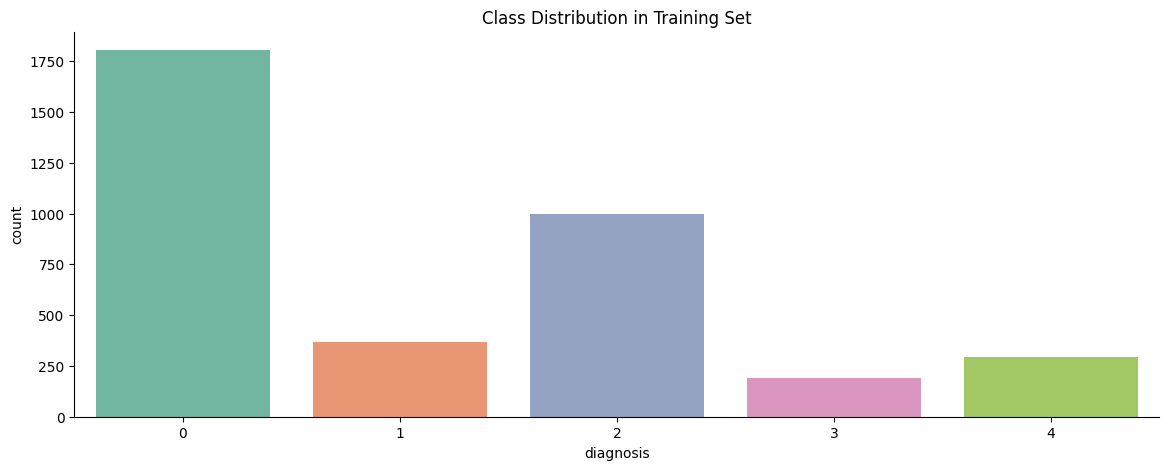

In [11]:
# class distribution in the training set
f, ax = plt.subplots(figsize=(14, 5))
ax = sns.countplot(x="diagnosis", data=train, palette="Set2")
sns.despine()
plt.title("Class Distribution in Training Set")
plt.show()

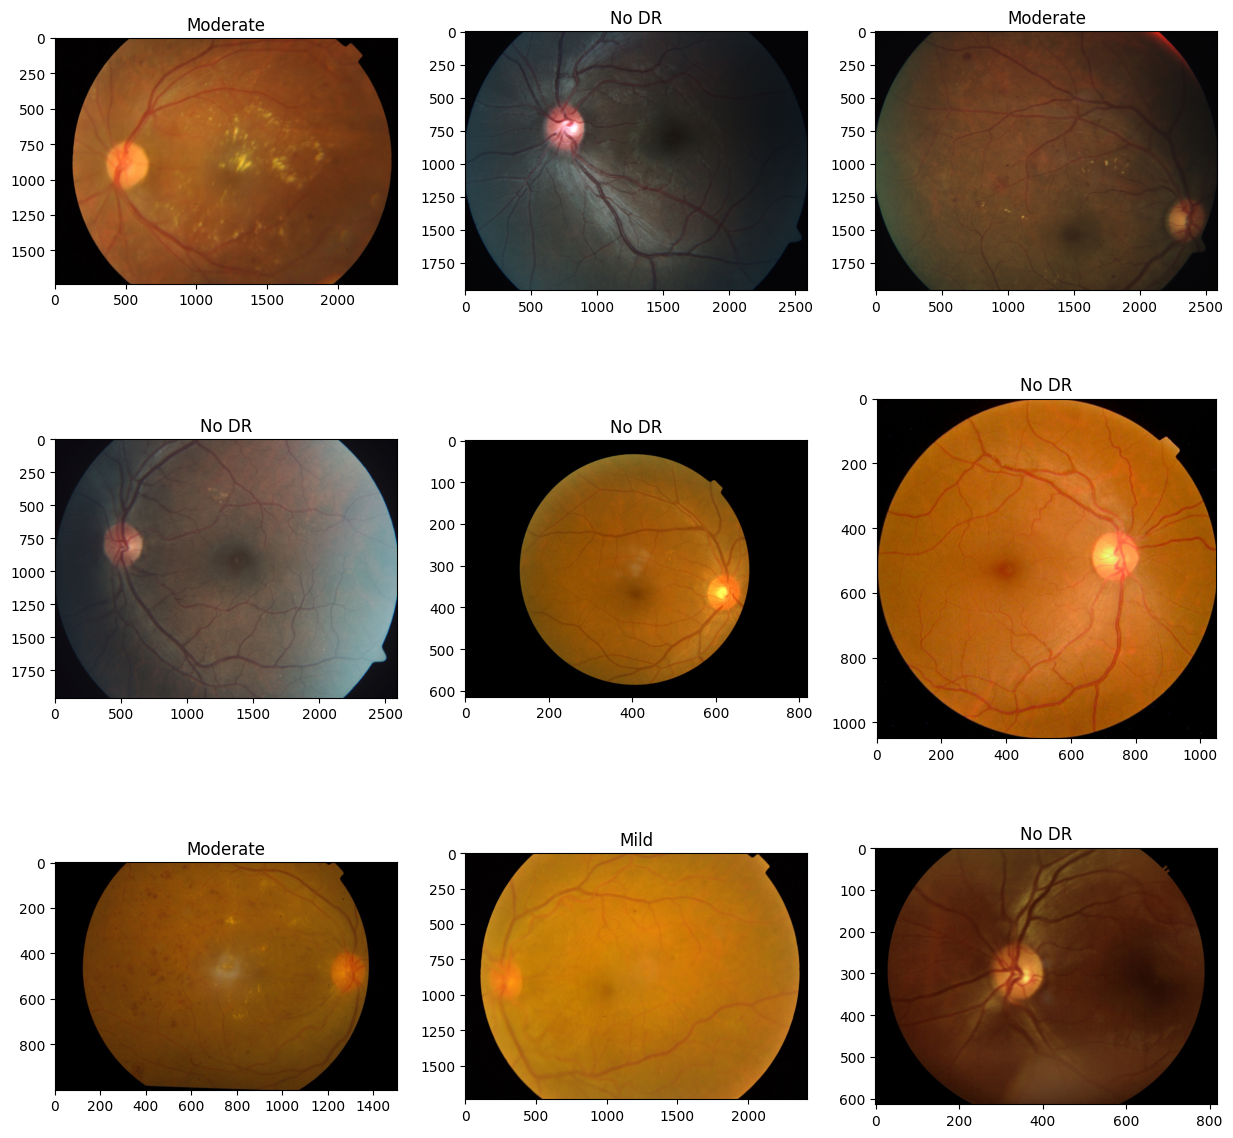

In [12]:
label_dic = {
    "0":"No DR",
    "1" : "Mild",
    "2":"Moderate",
    "3":"Severe",
    "4":"Proliferative DR"
}

#Checking Some Samples and Their Label

rows=3
cols = 3
count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))

indx = random.sample(range(train.shape[0]),rows * cols)

for i in range(rows):
    for j in range(cols):        
        if count < len(indx):
            img_path = "/kaggle/input/aptos2019-blindness-detection/train_images/"+train.iloc[indx[count],0]+".png"
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(img)
            axes[i,j].set_title(label_dic[str(train.iloc[indx[count],1])])
            count+=1

In [13]:
# Combining classes into 3 categories
train['diagnosis'] = train['diagnosis'].replace({0: 0, 1: 1, 2: 1, 3: 2, 4: 2})

label_dict = {
    0: 'No Disease',
    1: 'Mild Disease',
    2: 'Severe Disease'
}

class_distribution = train['diagnosis'].value_counts().sort_index()
class_distribution.index = class_distribution.index.map(label_dict)

print("Updated class distribution:\n", class_distribution)

Updated class distribution:
 diagnosis
No Disease        1805
Mild Disease      1369
Severe Disease     488
Name: count, dtype: int64


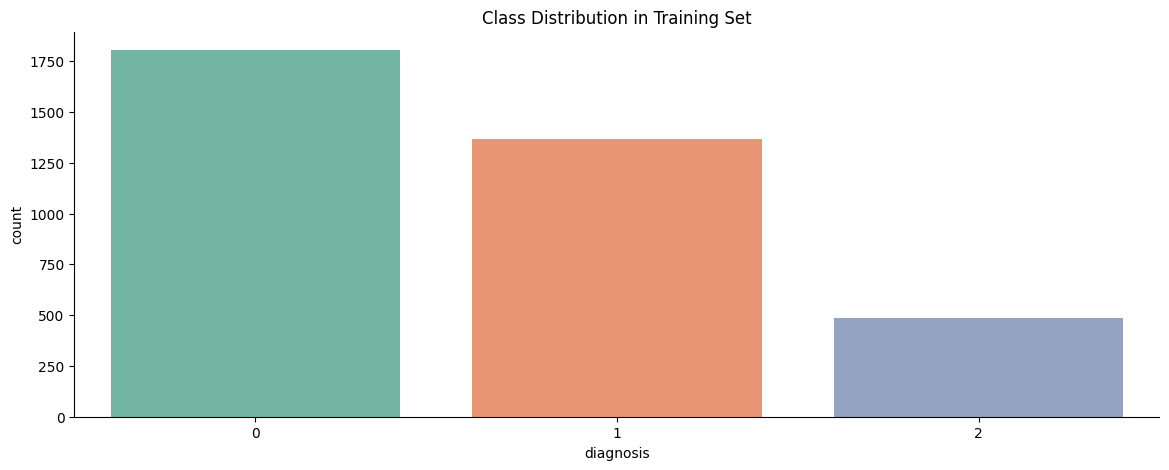

In [14]:
# Bar chart show the distribution of classes
f, ax = plt.subplots(figsize=(14, 5))
ax = sns.countplot(x="diagnosis", data=train, palette="Set2")
sns.despine()
plt.title("Class Distribution in Training Set")
plt.show()

In [15]:
# Appending '.png' to file names
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')

In [16]:
X = []
y = []

for i, row in tqdm(train.sample(len(train)).iterrows()):
    image_name = row.id_code
    image_path = os.path.join("/kaggle/input/aptos2019-blindness-detection/train_images", image_name)
    label = row.diagnosis

    # Read image
    image = cv2.imread(image_path)
    if image is not None:  # Check if image is loaded properly
        # Convert image to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Resize image to the defined IMAGE_SIZE
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

        # Rescale pixel values to the range [0, 1]
        image = image / 255.0

        # Append processed image and label to respective lists
        X.append(image)
        y.append(label)
    else:
        print(f"Image not found or unable to read: {image_path}")

# Convert lists to NumPy arrays
X = np.array(X, dtype='float32')
y = np.array(y, dtype='int32')

print(f"Shape of X (images): {X.shape}")
print(f"Shape of y (labels): {y.shape}")


3662it [06:27,  9.45it/s]


Shape of X (images): (3662, 224, 224, 3)
Shape of y (labels): (3662,)


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# One-hot encode the labels
y_encoded = to_categorical(y, num_classes=NUM_CLASSES)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y)

print(f"Shape of X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}, y_test: {y_test.shape}")

In [ ]:
# Define the ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,       # Random rotation
    width_shift_range=0.2,   # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,         # Shearing
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Horizontal flipping
    fill_mode="nearest"      # Fill mode for empty pixels
)

# Test data generator (no augmentation, only rescaling if needed)
test_datagen = ImageDataGenerator()

# Create data generators
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_generator = test_datagen.flow(
    X_test, y_test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Data generators are ready.")

In [ ]:
# Calculating class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train['diagnosis']),
    y=train['diagnosis']
)
class_weights_dict = dict(zip(np.unique(train['diagnosis']), class_weights))
print("Class Weights:", class_weights_dict)

# Modeling on Unbalanced Data

In [ ]:
# Model building function
def build_fusion_model(input_shape=(224, 224, 3), num_classes= NUM_CLASSES, dropout_rate=0.5):
    input_layer = Input(shape=input_shape)

    # EfficientNetB0
    efficient_net = EfficientNetB0(include_top=False, input_tensor=input_layer, weights='imagenet')

    i = 0
    for i, layer in enumerate(efficient_net.layers):
      if i < 10:
        layer.trainable = True
        i += 1
      else:
        layer.trainable = False
    efficient_output = GlobalAveragePooling2D()(efficient_net.output)

    # InceptionV3
    inception_v3 = InceptionV3(include_top=False, input_tensor=input_layer, weights='imagenet')
    i = 0
    for i, layer in enumerate(inception_v3.layers):
      if i < 10:
        layer.trainable = True
        i += 1
      else:
        layer.trainable = False
    inception_output = GlobalAveragePooling2D()(inception_v3.output)

    # Concatenate outputs
    combined_output = concatenate([efficient_output, inception_output])

    # Fully connected layers with dropout
    x = Dense(256, activation='relu')(combined_output)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model

In [ ]:
# Building the fusion model
fusion_model = build_fusion_model(input_shape=(224, 224, 3), num_classes= NUM_CLASSES , dropout_rate=0.5)

# Compile the model 
fusion_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Path to save the best model
checkpoint_path = "best_fusion_model.keras"

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,  # Path to save the model
    monitor='val_loss',       # Metric to monitor
    save_best_only=True,      # Save only the best model
    mode='min',               # Mode to minimize val_loss
    verbose=1                 # Print saving details
)

# Create an EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',       # Metric to monitor
    patience=7,               # Number of epochs with no improvement to stop
    mode='min',               # Mode to minimize val_loss
    verbose=1                 # Print stopping details
)

In [ ]:
# Training the model 
history = fusion_model.fit(train_generator, 
                           validation_data=test_generator, 
                           epochs=EPOCHS,
                           class_weight=class_weights_dict,
                           callbacks=[checkpoint_callback, early_stopping_callback]  # Added callbacks here
                          )

In [ ]:
def plot_history(history):
    # Plotting the training and validation accuracy/loss
    plt.figure(figsize=(12, 4))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()


plot_history(history)

In [ ]:
# Getting true labels and predictions
y_true = y_test.argmax(axis=1)
y_pred = np.argmax(fusion_model.predict(X_test), axis=1)
class_labels = list(label_dict.values())

In [ ]:
def evaluate_model(y_true, y_pred, class_labels):
    # Calculating accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    # Displaying classification report
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

    # Generating and ploting the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Plotting the ROC curve for each class
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
    n_classes = y_true_bin.shape[1]
    y_pred_bin = label_binarize(y_pred, classes=[0, 1, 2])
    plt.figure(figsize=(10, 6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {label_dict[i]} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend(loc='lower right')
    plt.show()